In [6]:
import os
import requests
import xml.etree.ElementTree as ET
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
nltk.download('punkt')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /Users/balazs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/balazs/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Search API function
def search_api(root, output_dir, pageSize, url_template):
    # Loop through topics and search for the top 1000 arguments
    for topic in root.findall('topic'):
        topic_number = topic.find('number')
        if topic_number is not None:
            topic_id = topic_number.text
            topic_title = topic.find('title')
            if topic_title is not None and topic_title.text:
                topic_title = topic_title.text.strip()
            else:
                topic_title = ''
                
            url = url_template.format(topic_title, pageSize)

            # Execute the search query on Elasticsearch
            response = requests.get(url).json()
            results = response['arguments']
            print (len(results))
            
            # Save the top 1000 arguments for the current topic to a file
            os.makedirs(output_dir, exist_ok=True)
            topic_file_name = os.path.join(output_dir, f"{topic_id}.txt")
            header = ['id', 'conclusion', 'premises', 'stance', 'rank']
            arguments = []
            for i, result in enumerate(results):
                argument = [result['id'], result['conclusion'], result['premises'][0]['text'], result['stance'], i + 1]
                arguments.append(argument)
            
            retrieved_arguments_pd = pd.DataFrame(arguments, columns=header)
            retrieved_arguments_pd.to_csv(topic_file_name, sep='\t')


In [8]:
# Create runfiles using API
def make_runfile(root, output_dir, pageSize, url_template, run_tag):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Set the output file name
    output_file_name = os.path.join(output_dir, "runfile21.txt")
    # Open the output file for writing
    with open(output_file_name, 'w') as f:
        # Loop through topics and search for the top 50 arguments
        for topic in root.findall('topic'):
            topic_number = topic.find('number')
            if topic_number is not None:
                topic_id = topic_number.text
                topic_title = topic.find('title')
                if topic_title is not None and topic_title.text:
                    topic_title = topic_title.text.strip()
                else:
                    topic_title = ''
                    
                # Format the search URL with the topic title and page size
                url = url_template.format(topic_title, pageSize)

                # Execute the search query
                response = requests.get(url).json()
                # Get the top 50 results
                results = response['arguments'][:50]
                print (len(results))
                
                # Loop through the top 50 results
                for i, result in enumerate(results):
                    # Get the argument ID, rank, and score
                    argument_id = result['id']
                    rank = i + 1
                    score = result['explanation']['score']
                    # Format the output line
                    line = f"{topic_id} Q0 {argument_id} {rank} {score} {run_tag}\n"
                    # Write the output line to the file
                    f.write(line)

In [9]:
def extract_features(directory):
    corpus = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as f:
                corpus.append(f.read())

    print(f'Number of documents in corpus: {len(corpus)}')

    # Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_features = [sia.polarity_scores(doc) for doc in corpus]
    
    # Convert sentiment features from dictionaries to numpy arrays
    sentiment_keys = ['neg', 'neu', 'pos', 'compound']
    X_sentiment = np.array([[doc[key] for key in sentiment_keys] for doc in sentiment_features])

    # Bag-of-Words
    vectorizer = CountVectorizer()
    bow_features = vectorizer.fit_transform(corpus).toarray()

    # Word2Vec
    tokenized_corpus = [word_tokenize(doc) for doc in corpus]
    
    model = Word2Vec(tokenized_corpus, vector_size=300, min_count=1)
    
    print(f'Vocabulary size: {len(model.wv)}')
    print(f'Embedding dimension: {model.vector_size}')

    w2v_features = []
    for doc in tokenized_corpus:
        doc_vectors = [model.wv[word] for word in doc if word in model.wv]
        if len(doc_vectors) > 0:
            doc_features = np.mean(doc_vectors, axis=0)
        else:
            # Handle empty documents or documents with no known words
            doc_features = np.zeros(model.vector_size)
        w2v_features.append(doc_features)

    # Combine features
    X_bow = np.array(bow_features)
    X_w2v = np.array(w2v_features)
    
    # Print shapes
    print(f'X_sentiment shape: {X_sentiment.shape}')
    print(f'X_bow shape: {X_bow.shape}')
    print(f'X_w2v shape: {X_w2v.shape}')

    X_combined = np.concatenate((X_sentiment, X_bow, X_w2v), axis=1)

    # Return extracted features
    print("successful extraction")
    return X_combined


In [10]:
def plot_sentiment_scores(X_sentiment):
    # Compute average sentiment scores
    avg_scores = X_sentiment.mean(axis=0)
    
    # Create bar chart
    sentiment_keys = ['Negative', 'Neutral', 'Positive', 'Compound']
    plt.bar(sentiment_keys, avg_scores)
    
    # Add labels and title
    plt.xlabel('Sentiment')
    plt.ylabel('Average Score')
    plt.title('Average Sentiment Scores for All Documents')
    
    # Show plot
    plt.show()

In [11]:
# Load the XML files for 2020
tree20 = ET.parse('/Users/balazs/Desktop/dissertationProjectCode/dissertationCodeBase/Data/topic_files/topics-task-1-2020.xml')
root20 = tree20.getroot()

# Load the XML files for 2021
tree21 = ET.parse('/Users/balazs/Desktop/dissertationProjectCode/dissertationCodeBase/Data/topic_files/topics-task-1-only-titles.xml')
root21 = tree21.getroot()

# Define the output directories for 2020
output_dir20 = "/Users/balazs/Desktop/dissertationProjectCode/dissertationCodeBase/Data/args20api/"

# Define the output directories for 2021
output_dir21 = "/Users/balazs/Desktop/dissertationProjectCode/dissertationCodeBase/Data/args21api/"

pageSize = 1000
url_template = "https://args.me/api/v2/arguments?query={}&corpora=args-me-2020-04-01&pageSize={}&format=json"
#url_template = "https://args.me/api/v2/arguments?query={}&pageSize={}&format=json"

In [12]:
# Call search functions for 2020
search_api(root20, output_dir20, pageSize, url_template)

#Call search functions for 2021
search_api(root21, output_dir21, pageSize, url_template)

41
6
0
0
0
1000
51
84
27
0
0
0
0
7
0
0
6
0
8
0
214
29
15
0
14
0
0
0
42
69
0
203
0
0
151
2
339
0
0
0
0
0
22
0
0
0
0
6
148
0
0
0
162
0
0
0
0
0
0
802
0
10
0
23
1000
0
0
0
0
0
8
0
54
126
1000
10
14
326
0
0
160
0
21
0
5
2
8
0
2
0
8
0
2
0
0
0
0
0
0


In [13]:
# Call search functions for 2020
make_runfile(root20, output_dir20, pageSize, url_template, "40323335_Run_File_20")

# Call search functions for 2021
make_runfile(root21, output_dir21, pageSize, url_template, "40323335_Run_File_21")

41
6
0
0
0
50
50
50
27
0
0
0
0
7
0
0
6
0
8
0
50
29
15
0
14
0
0
0
42
50
0
50
0
0
50
2
50
0
0
0
0
0
22
0
0
0
0
6
50
0
0
0
50
0
0
0
0
0
0
50
0
10
0
23
50
0
0
0
0
0
8
0
50
50
50
10
14
50
0
0
50
0
21
0
5
2
8
0
2
0
8
0
2
0
0
0
0
0
0


In [14]:
directory = '/Users/balazs/Desktop/dissertationProjectCode/dissertationCodeBase/Data/args20api'
features20 = extract_features(directory)

Number of documents in corpus: 50


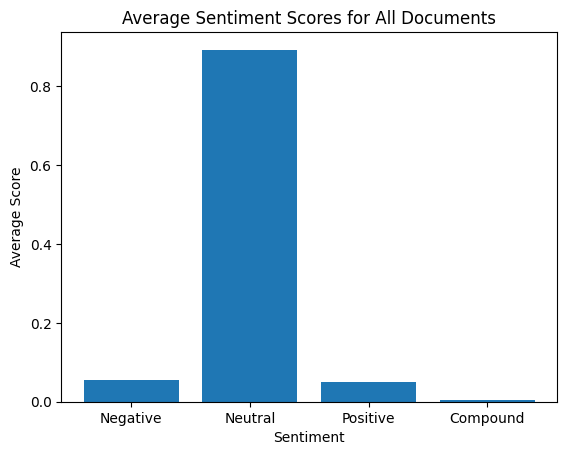

In [ ]:
# Extract sentiment features from X_combined
X_sentiment = features20[:, :4]
X_sarcasm = features20
# Plot sentiment scores
plot_sentiment_scores(X_sentiment)